# Dernier checkpoint - formation data analyst
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/h4r1c0t/WildCodeSchool/master?filepath=Odyssey%2FCheckpoint%2F%234_Final%2FCP4_sujet1.ipynb)
___
## Sujet n°1 : SQL Database
##### import

In [2]:
# Classical libraries
import pandas as pd
import numpy as np

# SQL connection libraries
import requests
import sqlite3

# Mapping libraries
import geopandas as gpd
import folium
import rtree
from shapely.geometry import Point
from shapely.ops import transform
from IPython.display import display

# Ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Dashboard libraries
import dash

### Open dataset

In [3]:
# Get dataset from github.com
link = 'https://github.com/murpi/wilddata/raw/master/quests/chinook.db'
r = requests.get(link)
open('./datasets/chinook.db', 'wb').write(r.content)

# Create connector
conn = sqlite3.connect('./datasets/chinook.db')
cursor = conn.cursor()

### DB schemas

![schemas](http://images.innoveduc.fr/data/SQL/SQLite_chinook.png)

___
### 1. Mapping of sales by country, and comparison with customer and employee addresses
#### Explore dataset
##### Invoices table:

In [4]:
df_invoices = pd.read_sql("SELECT * FROM invoices", conn)
df_invoices.head(3)

InvoiceId  CustomerId          InvoiceDate           BillingAddress  \
0          1           2  2009-01-01 00:00:00  Theodor-Heuss-Straße 34   
1          2           4  2009-01-02 00:00:00         Ullevålsveien 14   
2          3           8  2009-01-03 00:00:00          Grétrystraat 63   

  BillingCity BillingState BillingCountry BillingPostalCode  Total  
0   Stuttgart         None        Germany             70174   1.98  
1        Oslo         None         Norway              0171   3.96  
2    Brussels         None        Belgium              1000   5.94

In [5]:
# Change date format to 'DateTime'
df_invoices['InvoiceDate'] = pd.to_datetime(df_invoices['InvoiceDate'])

df_invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   InvoiceId          412 non-null    int64         
 1   CustomerId         412 non-null    int64         
 2   InvoiceDate        412 non-null    datetime64[ns]
 3   BillingAddress     412 non-null    object        
 4   BillingCity        412 non-null    object        
 5   BillingState       210 non-null    object        
 6   BillingCountry     412 non-null    object        
 7   BillingPostalCode  384 non-null    object        
 8   Total              412 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 29.1+ KB


In [6]:
# Isolate the year, month and day of the invoices. 
df_invoices['InvoiceYear'] = df_invoices['InvoiceDate'].apply(lambda x: str(x)[:4])
df_invoices['InvoiceMonth'] = df_invoices['InvoiceDate'].apply(lambda x: str(x)[5:7])
df_invoices['InvoiceDay'] = df_invoices['InvoiceDate'].apply(lambda x: str(x)[8:10])

In [7]:
# Columns filling rate:
round((1 - df_invoices.isna().sum()/len(df_invoices)) *100, 2)

InvoiceId            100.00
CustomerId           100.00
InvoiceDate          100.00
BillingAddress       100.00
BillingCity          100.00
BillingState          50.97
BillingCountry       100.00
BillingPostalCode     93.20
Total                100.00
InvoiceYear          100.00
InvoiceMonth         100.00
InvoiceDay           100.00
dtype: float64

##### Customers table:

In [8]:
df_customers = pd.read_sql("SELECT * FROM customers", conn)
df_customers.head(3)

CustomerId FirstName   LastName  \
0           1      Luís  Gonçalves   
1           2    Leonie     Köhler   
2           3  François   Tremblay   

                                            Company  \
0  Embraer - Empresa Brasileira de Aeronáutica S.A.   
1                                              None   
2                                              None   

                           Address                 City State  Country  \
0  Av. Brigadeiro Faria Lima, 2170  São José dos Campos    SP   Brazil   
1          Theodor-Heuss-Straße 34            Stuttgart  None  Germany   
2                1498 rue Bélanger             Montréal    QC   Canada   

  PostalCode               Phone                 Fax                  Email  \
0  12227-000  +55 (12) 3923-5555  +55 (12) 3923-5566   luisg@embraer.com.br   
1      70174    +49 0711 2842222                None  leonekohler@surfeu.de   
2    H2G 1A7   +1 (514) 721-4711                None    ftremblay@gmail.com   

   SupportRepId  
0             3  
1             5  
2             3

In [9]:
# Columns filling rate:
round((1 - df_customers.isna().sum()/len(df_customers)) *100, 2)

CustomerId      100.00
FirstName       100.00
LastName        100.00
Company          16.95
Address         100.00
City            100.00
State            50.85
Country         100.00
PostalCode       93.22
Phone            98.31
Fax              20.34
Email           100.00
SupportRepId    100.00
dtype: float64

##### Employees table:

In [10]:
df_employees = pd.read_sql("SELECT * FROM employees", conn)
df_employees.head(3)

EmployeeId LastName FirstName                Title  ReportsTo  \
0           1    Adams    Andrew      General Manager        NaN   
1           2  Edwards     Nancy        Sales Manager        1.0   
2           3  Peacock      Jane  Sales Support Agent        2.0   

             BirthDate             HireDate              Address      City  \
0  1962-02-18 00:00:00  2002-08-14 00:00:00  11120 Jasper Ave NW  Edmonton   
1  1958-12-08 00:00:00  2002-05-01 00:00:00         825 8 Ave SW   Calgary   
2  1973-08-29 00:00:00  2002-04-01 00:00:00        1111 6 Ave SW   Calgary   

  State Country PostalCode              Phone                Fax  \
0    AB  Canada    T5K 2N1  +1 (780) 428-9482  +1 (780) 428-3457   
1    AB  Canada    T2P 2T3  +1 (403) 262-3443  +1 (403) 262-3322   
2    AB  Canada    T2P 5M5  +1 (403) 262-3443  +1 (403) 262-6712   

                    Email  
0  andrew@chinookcorp.com  
1   nancy@chinookcorp.com  
2    jane@chinookcorp.com

In [11]:
# Columns filling rate:
round((1 - df_employees.isna().sum()/len(df_employees)) *100, 2)

EmployeeId    100.0
LastName      100.0
FirstName     100.0
Title         100.0
ReportsTo      87.5
BirthDate     100.0
HireDate      100.0
Address       100.0
City          100.0
State         100.0
Country       100.0
PostalCode    100.0
Phone         100.0
Fax           100.0
Email         100.0
dtype: float64

#### Turnover per country

In [12]:
df_turnover_country = df_invoices.groupby(
    by = [
    'BillingCountry', 
    'InvoiceYear'
#         , 
#     'InvoiceMonth'
    ]
).sum(
).reset_index(
).drop(
    ['InvoiceId', 'CustomerId'], 
    axis = 1
).rename(
    columns = {
        'BillingCountry': 'Country', 
        'InvoiceYear': 'Year', 
#         'InvoiceMonth': 'Month', 
        'Total': 'Turnover'}
)

df_turnover_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   101 non-null    object 
 1   Year      101 non-null    object 
 2   Turnover  101 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.5+ KB


#### Map creation
##### Import countries coordinates from geo.json

In [13]:
# Import geo.json data 
world = "https://raw.githubusercontent.com/h4r1c0t/WildCodeSchool/master/Odyssey/Checkpoint/%234_Final/Sujet1/datasets/world.geo.json"
df_world = gpd.read_file(world)
df_world.shape

(232, 65)

In [14]:
# Rename USA to 'United States of America' to match the geo.json DF
df_turnover_country['Country'][df_turnover_country['Country'] == 'USA'] = 'United States of America'

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# List of the countries in our DB
countries_to_keep = df_turnover_country['Country'].unique()

> There is **232** countries in the *geo.json* file, but only **24** in our dataset. 

In [16]:
# Keep only the countries which are in our dataset
df_country = df_world[['admin', 'geometry']][df_world['admin'].isin(countries_to_keep)]
df_country.shape

(24, 2)

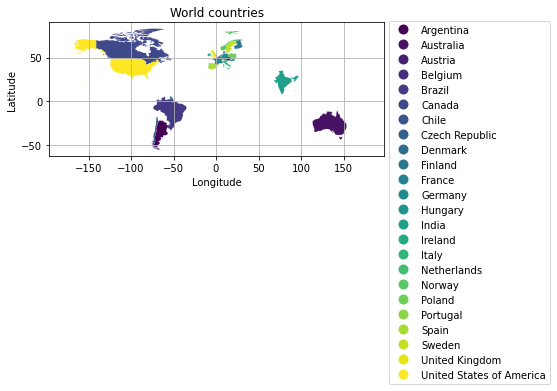

In [17]:
# Show selected contries on simple map

legend_param = {'loc':'upper left', 'bbox_to_anchor': (1, 1.05)}

df_country.plot(column = 'admin',  cmap = 'viridis', legend = True, legend_kwds = legend_param)
plt.title('World countries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

##### Map with Turnover Chlorepleth

In [18]:
years = ['2009', '2010', '2011']
map_data = df_turnover_country[df_turnover_country['Year'].isin(years)]
map_data = map_data.groupby('Country').sum().reset_index()

map_data_geo = pd.merge(df_country, map_data, left_on = 'admin', right_on = 'Country').drop('Country', axis = 1)
map_data_geo.head()

admin  \
0                    Canada   
1  United States of America   
2                 Argentina   
3                    Brazil   
4                     Chile   

                                            geometry  Turnover  
0  MULTIPOLYGON (((-59.78760 43.93960, -59.92227 ...    189.12  
1  MULTIPOLYGON (((-155.58135 19.01201, -155.6256...    309.94  
2  MULTIPOLYGON (((-64.54917 -54.71621, -64.43882...     12.87  
3  MULTIPOLYGON (((-48.48589 -27.76699, -48.55459...     99.02  
4  MULTIPOLYGON (((-67.57520 -55.88965, -67.61143...     39.69

In [19]:
turnover_map = folium.Map(location = [45, 0], zoom_start = 2)

turnover_map.choropleth(
    geo_data = map_data_geo,
    name = 'Turnover',
    data = map_data_geo,
    columns = ['admin', 'Turnover'],
    key_on = 'feature.properties.admin',
    fill_color = 'Blues',
    fill_opacity = .5,
    line_opacity = 1.0,
    legend_name = 'Turnover by country'
)   

# tunover_map.add

folium.LayerControl().add_to(turnover_map)


display(turnover_map)

C:\Users\vanst\miniconda3\lib\site-packages\folium\folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



##### Add Customers localisation

In [20]:
df_world.shape

(232, 65)

In [33]:
# Keep only cities which are in customers DF
cust_countries = df_customers.Country.unique()

# Keep only cities which are in employees DF
empl_countries = df_employees.Country.unique()

In [37]:
# How many countries?
print("Nb customers countries: " + str(len(cust_countries)))
print("Nb employees countries: " + str(len(empl_countries)))

cust_countries_geo = df_world[['admin', 'geometry']][df_world['admin'].isin(cust_countries)]
empl_countries_geo = df_world[['admin', 'geometry']][df_world['admin'].isin(empl_countries)]

Nb customers countries: 24
Nb employees countries: 1


In [38]:
print('Nb customers cities coordinate: ' + str(len(cust_countries_geo.admin.unique())))
print('Nb employees cities coordinate: ' + str(len(empl_countries_geo.admin.unique())))

Nb customers cities coordinate: 23
Nb employees cities coordinate: 1


##### Add marker for customers 

In [39]:
df_nbcustomers = df_customers.groupby(['Country']).count().reset_index().rename(columns={'CustomerId': 'nbCust'})

df_customers_countries = pd.merge(cust_countries_geo, df_nbcustomers, left_on = 'admin', right_on = 'Country')

# Compute the centroid of each country
# df_customers_countries['geometry2'] = df_customers_countries['geometry'].to_crs(epsg = 6933)
df_customers_countries['center'] = df_customers_countries.geometry.centroid


for row in df_customers_countries.iterrows():
  location = [row[1].center.y, row[1].center.x]
  popup = ('<b>Country:</b>' + str(row[1].admin) +
           '<br><b>Nb customers:</b>' + str(row[1].nbCust))
  radius = row[1].nbCust *50000
  circle = folium.Circle(location = location,
                         popup = popup,
                         radius = radius,
                         color = 'crimson',
                         fill = True,
                         fill_color = 'crimson')

  circle.add_to(turnover_map)

display(turnover_map)

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




AttributeError: 'Series' object has no attribute 'nbCust'

___
### 2. Preferred music format and genre
#### Get data

In [27]:
query = """
    SELECT  g.Name Genre, mt.Name Format, 
            TotalOrdered
    FROM tracks t
    JOIN (
        SELECT TrackId, SUM(Quantity) TotalOrdered
        FROM invoice_items
        GROUP BY TrackId
    ) ii 
    ON ii.TrackId = t.TrackId
    JOIN (
        SELECT *
        FROM genres
    ) g 
    ON g.GenreId = t.GenreId
    JOIN (
        SELECT * 
        FROM media_types
    ) mt
    ON mt.MediaTypeId = t.MediaTypeId
"""

df_favO = pd.read_sql(query, conn)


#### Favorite **genre** based on Total ordered 

In [43]:
df_favO_genre = df_favO.groupby(["Genre"]).sum().sort_values("TotalOrdered", ascending = False).reset_index()

low_ordered = df_favO_genre[df_favO_genre['TotalOrdered'] < 80]
low_ordered['GenreBis'] = 'Other'

high_ordered = df_favO_genre[df_favO_genre['TotalOrdered'] >= 80]
high_ordered['GenreBis'] = high_ordered['Genre'].apply(lambda x: x)

df_favO_genre = pd.concat([high_ordered, low_ordered], axis = 0)
df_favO_genre.head()

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre  TotalOrdered            GenreBis
0                Rock           835                Rock
1               Latin           386               Latin
2               Metal           264               Metal
3  Alternative & Punk           244  Alternative & Punk
4                Jazz            80                Jazz

##### BarChart

In [29]:
genreBarChart = go.Figure()

for genre in df_favO_genre['GenreBis'].unique():
    x = df_favO_genre['GenreBis'][df_favO_genre['GenreBis'] == genre]
    y = df_favO_genre['TotalOrdered'][df_favO_genre['GenreBis'] == genre]
    genreBarChart.add_trace(go.Bar(x = x, y = y, name = genre, width = 1))

genreBarChart.update_layout(
    autosize = True,
    title = {'text': 'Genre repartition in invoices',
             'y': .92,
             'x': .5,
             'xanchor': 'center',
             'yanchor': 'top'},
    xaxis_title='Genres',
    yaxis_title='Number of tracks',
    font = dict(
        family = "Arial, regular",
        size = 16,
        color = '#154360')
)

# op(fig)
py.iplot(genreBarChart)

##### PieChart

In [30]:
labels = df_favO_genre['GenreBis']
values = df_favO_genre['TotalOrdered']

genrePieChart = go.Figure()

genrePieChart.add_trace(go.Pie(labels = labels, values = values))
genrePieChart.update_layout(
    autosize = True,
    title = {'text': 'Genre repartition in invoices',
             'y': .92,
             'x': .5,
             'xanchor': 'center',
             'yanchor': 'top'},
    font = dict(
        family = "Arial, regular",
        size = 16,
        color = '#154360')
)

# op(fig)
py.iplot(genrePieChart)

#### Favorite **format** based on Total ordered 

In [48]:
df_favO_format = df_favO.groupby(["Format"]).sum().sort_values("TotalOrdered", ascending = False).reset_index()

low_ordered = df_favO_format[df_favO_format['TotalOrdered'] < 10]
low_ordered['FormatBis'] = 'Other'
high_ordered = df_favO_format[df_favO_format['TotalOrdered'] >= 10]
high_ordered['FormatBis'] = high_ordered['Format'].apply(lambda x: x)

df_favO_format = pd.concat([high_ordered, low_ordered], axis = 0)

df_favO_format.head()

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Format  TotalOrdered                    FormatBis
0              MPEG audio file          1976              MPEG audio file
1     Protected AAC audio file           146     Protected AAC audio file
2  Protected MPEG-4 video file           111  Protected MPEG-4 video file
3     Purchased AAC audio file             4                        Other
4               AAC audio file             3                        Other

In [49]:
labels = df_favO_format['FormatBis']
values = df_favO_format['TotalOrdered']

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

formatPieChart = go.Figure(data=[go.Pie(labels=labels, values=values, hole = .25)])
formatPieChart.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=1.5)))

formatPieChart.update_layout(
    autosize=True,
    title = {'text': 'Format repartition in invoices',
             'y': .92,
             'x': .5,
             'xanchor': 'center',
             'yanchor': 'top'},
    font = dict(
        family = "Arial, regular",
        size = 16,
        color = '#154360')
)

# op(fig)
py.iplot(formatPieChart)

___
### 3. Most represented artists
#### Get data

In [106]:
query = """
    SELECT Artist, Genre, COUNT(TrackId) Number
    FROM tracks t 
    JOIN (
        SELECT Name Genre, GenreId
        FROM genres
    ) g ON g.GenreId = t.GenreId
    JOIN (
        SELECT AlbumId, ArtistId
        FROM albums
    ) alb ON alb.AlbumId = t.AlbumId
    JOIN (
        SELECT Name Artist, ArtistId
        FROM artists
    ) art ON art.ArtistId = alb.ArtistId
    GROUP BY Artist, Genre 
    ORDER BY Number DESC
"""

df_artist = pd.read_sql(query, conn)
df_artist.head()

Artist  Genre  Number
0  Led Zeppelin   Rock     114
1     Metallica  Metal     112
2            U2   Rock     112
3   Iron Maiden  Metal      95
4   Deep Purple   Rock      92

In [107]:
genres = df_artist.groupby(["Genre"]).sum().sort_values(['Number'], ascending = False).reset_index()
genres.head()

Genre  Number
0                Rock    1297
1               Latin     579
2               Metal     374
3  Alternative & Punk     332
4                Jazz     130

In [108]:
df_artist['Freq'] = 0

for genre in genres['Genre']:
    nb_tracks = int(genres["Number"][genres["Genre"] == genre])
    df_artist['Freq'][df_artist['Genre'] == genre] = df_artist['Number'][df_artist['Genre'] == genre].apply(lambda x: x/nb_tracks*100)

df_artist

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vanst\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Artist      Genre  Number       Freq
0                                  Led Zeppelin       Rock     114   8.789514
1                                     Metallica      Metal     112  29.946524
2                                            U2       Rock     112   8.635312
3                                   Iron Maiden      Metal      95  25.401070
4                                   Deep Purple       Rock      92   7.093292
..                                          ...        ...     ...        ...
228  The 12 Cellists of The Berlin Philharmonic  Classical       1   1.351351
229                                 Ton Koopman  Classical       1   1.351351
230                              Wilhelm Kempff  Classical       1   1.351351
231                              Yehudi Menuhin  Classical       1   1.351351
232                                    Yo-Yo Ma  Classical       1   1.351351

[233 rows x 4 columns]

In [109]:
favArtistBarChart = go.Figure()

for genre in genres:
    plt_data = df_artist[df_artist['Genre'] == genre]
    x = plt_data['Artist'].head(10)
    y = plt_data['Freq'].head(10)

    favArtistBarChart.add_trace(go.Bar(x = x, y = y,
                         name = genre))

favArtistBarChart.update_layout(
    autosize = True,
    title = {'text': '10th most represented artist as function of genre',
             'y': .92,
             'x': .5,
             'xanchor': 'center',
             'yanchor': 'top'},
    xaxis_title = 'Artists',
    yaxis_title = 'Frequency (%)',
    font = dict(
        family = "Arial, regular",
        size = 16,
        color = '#154360')
)
favArtistBarChart.update_xaxes(
    tickangle = 45
)

favArtistBarChart.update_layout(barmode = 'stack')

py.iplot(favArtistBarChart)
# op(fig)

___
### 4. Prediction of top-selling music and determination of the criteria associated with them

> Je n'ai pas eu le temps de faire ce que j'aurai souhaité.. Je n'ai pas pu avancer comme je le voulais jeudi.<br>
> J'apporterai des modifications pour la présentation de lundi. 

#### Generate a track sales DF

In [37]:
query = """
    SELECT  t.TrackId, Name, ArtistId, t.AlbumId, 
            MediaTypeId, GenreId, Composer, 
            Milliseconds, Bytes, UnitPrice, 
            TotalOrdered
    FROM tracks t
    JOIN (
        SELECT TrackId, SUM(Quantity) TotalOrdered
        FROM invoice_items
        GROUP BY TrackId
    ) ii
    ON t.TrackId = ii.TrackId
    JOIN (
        SELECT AlbumId, ArtistId
        FROM albums
    ) a
"""

df_tracks = pd.read_sql(query, conn)
df_tracks.head()

TrackId                                     Name  ArtistId  AlbumId  \
0        1  For Those About To Rock (We Salute You)         1        1   
1        1  For Those About To Rock (We Salute You)         1        1   
2        1  For Those About To Rock (We Salute You)         2        1   
3        1  For Those About To Rock (We Salute You)         2        1   
4        1  For Those About To Rock (We Salute You)         3        1   

   MediaTypeId  GenreId                                   Composer  \
0            1        1  Angus Young, Malcolm Young, Brian Johnson   
1            1        1  Angus Young, Malcolm Young, Brian Johnson   
2            1        1  Angus Young, Malcolm Young, Brian Johnson   
3            1        1  Angus Young, Malcolm Young, Brian Johnson   
4            1        1  Angus Young, Malcolm Young, Brian Johnson   

   Milliseconds     Bytes  UnitPrice  TotalOrdered  
0        343719  11170334       0.99             1  
1        343719  11170334       0.99             1  
2        343719  11170334       0.99             1  
3        343719  11170334       0.99             1  
4        343719  11170334       0.99             1

In [38]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688448 entries, 0 to 688447
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   TrackId       688448 non-null  int64  
 1   Name          688448 non-null  object 
 2   ArtistId      688448 non-null  int64  
 3   AlbumId       688448 non-null  int64  
 4   MediaTypeId   688448 non-null  int64  
 5   GenreId       688448 non-null  int64  
 6   Composer      505579 non-null  object 
 7   Milliseconds  688448 non-null  int64  
 8   Bytes         688448 non-null  int64  
 9   UnitPrice     688448 non-null  float64
 10  TotalOrdered  688448 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 57.8+ MB


In [39]:
df_tracks.describe(include='all').T

count unique           top   freq         mean          std  \
TrackId       688448    NaN           NaN    NaN      1725.07      997.113   
Name          688448   1888   The Trooper   1388          NaN          NaN   
ArtistId      688448    NaN           NaN    NaN      121.942       77.681   
AlbumId       688448    NaN           NaN    NaN      139.043      80.9546   
MediaTypeId   688448    NaN           NaN    NaN      1.18095     0.531299   
GenreId       688448    NaN           NaN    NaN      5.32964      5.77294   
Composer      505579    572  Steve Harris  18391          NaN          NaN   
Milliseconds  688448    NaN           NaN    NaN       382793       523237   
Bytes         688448    NaN           NaN    NaN  3.12913e+07  1.03498e+08   
UnitPrice     688448    NaN           NaN    NaN      1.04192     0.221856   
TotalOrdered  688448    NaN           NaN    NaN      1.12903     0.335236   

                 min          25%          50%          75%          max  
TrackId            1       878.25         1720      2568.75         3500  
Name             NaN          NaN          NaN          NaN          NaN  
ArtistId           1           58          112          180          275  
AlbumId            1        70.75          141          207          344  
MediaTypeId        1            1            1            1            5  
GenreId            1            1            3            7           24  
Composer         NaN          NaN          NaN          NaN          NaN  
Milliseconds    6373       206935       256969       321915  5.28695e+06  
Bytes         211997  6.35435e+06  8.11348e+06  1.02693e+07  1.05955e+09  
UnitPrice       0.99         0.99         0.99         0.99         1.99  
TotalOrdered       1            1            1            1            2

##### Data vizualisation

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

C:\Users\vanst\miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Defaul

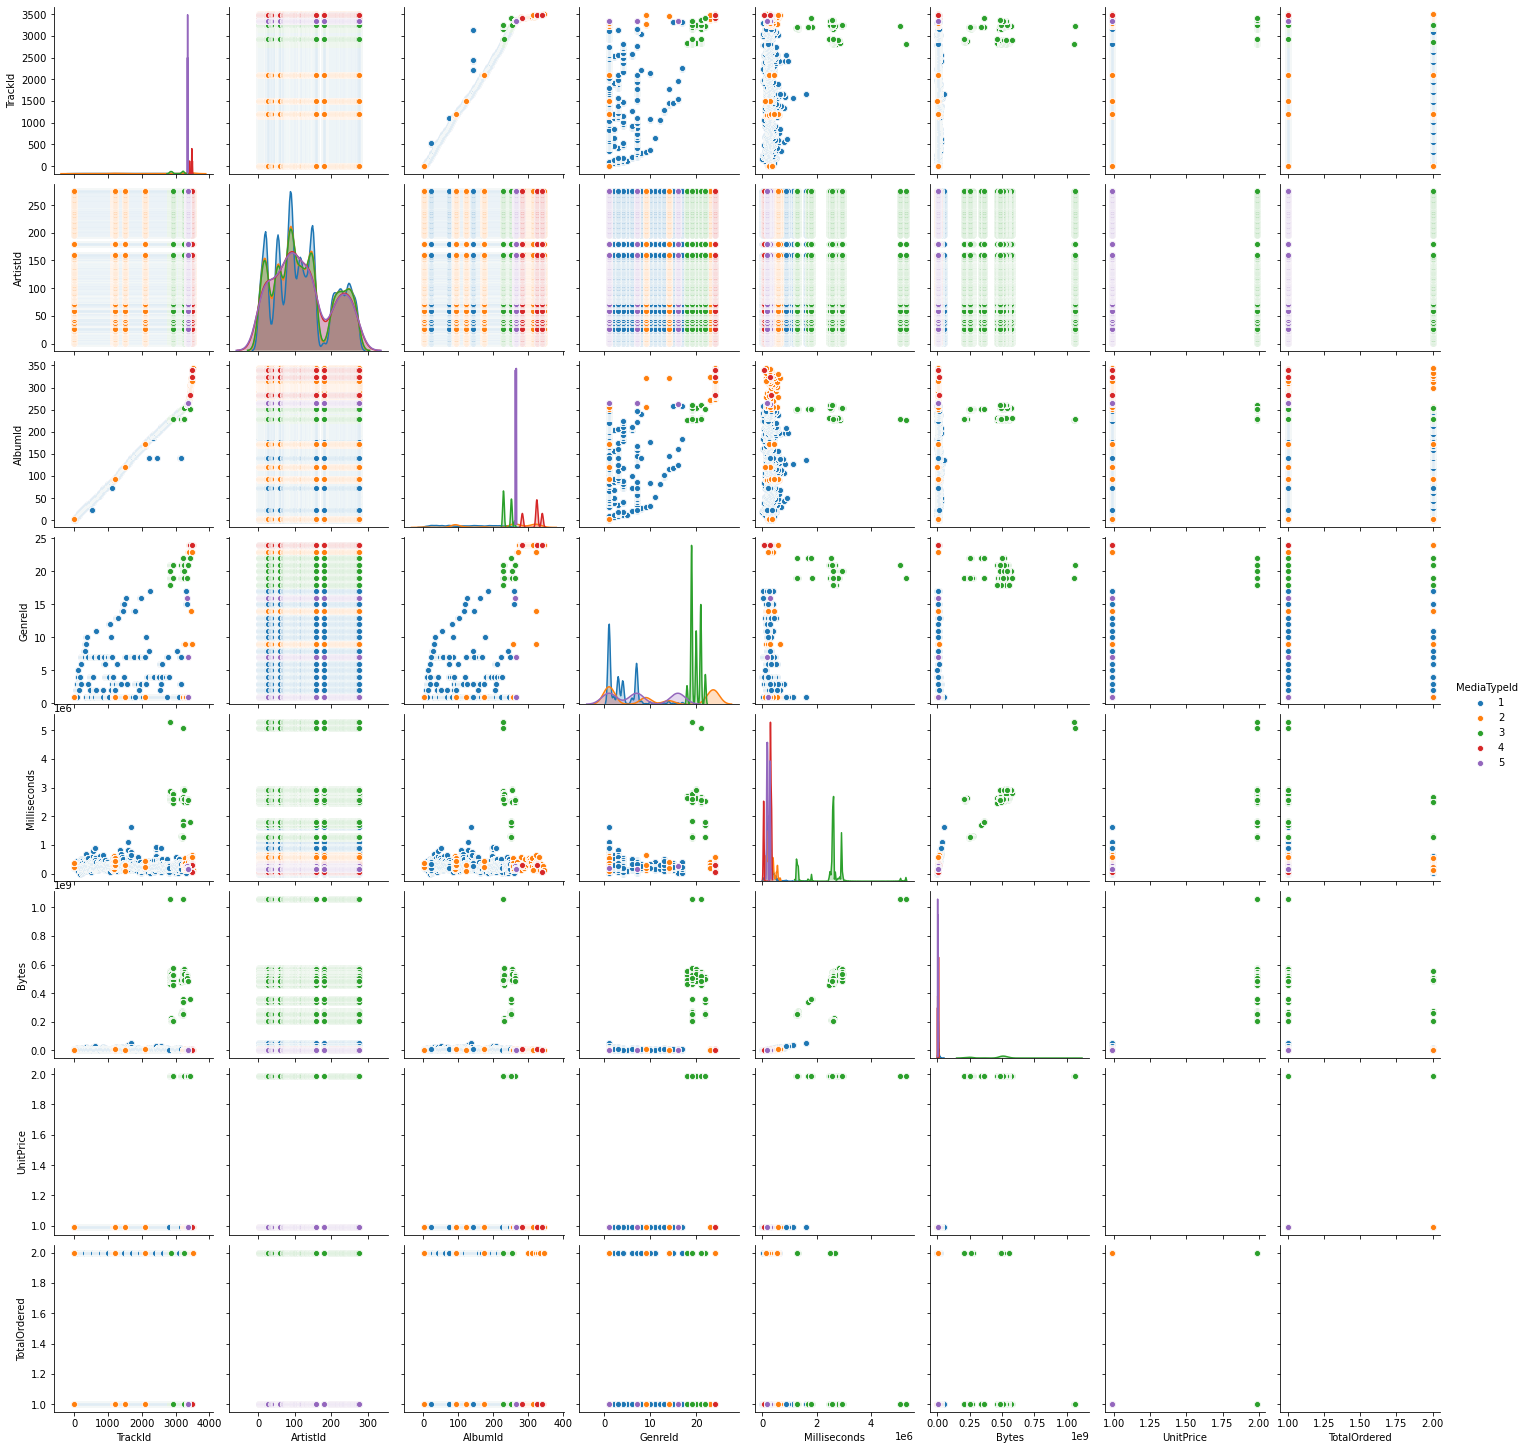

In [40]:
# Pairplot
sns.pairplot(df_tracks, hue = "MediaTypeId")
plt.show()

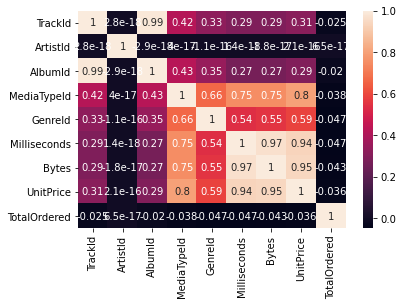

In [41]:
# Heatmap
sns.heatmap(df_tracks.corr(), annot = True)

In [42]:
df_tracks.groupby(["GenreId", "ArtistId"]).sum().sort_values("TotalOrdered", ascending = False).reset_index()

GenreId  ArtistId   TrackId  AlbumId  MediaTypeId  Milliseconds  \
0           1        90  27712503  2224719        16821    4430489070   
1           1        22  18475002  1483146        11214    2953659380   
2           1        58  14516073  1165329         8811    2320732370   
3           1        50  13196430  1059390         8010    2109756700   
4           1       150  13196430  1059390         8010    2109756700   
...       ...       ...       ...      ...          ...           ...   
4891       18       133     14146     1135           15      13206289   
4892       18       134     14146     1135           15      13206289   
4893       18       135     14146     1135           15      13206289   
4894       18       136     14146     1135           15      13206289   
4895       18        57     14146     1135           15      13206289   

             Bytes  UnitPrice  TotalOrdered  
0     140804466033   15488.55         17535  
1      93869644022   10325.70         11690  
2      73754720303    8113.05          9185  
3      67049745730    7375.50          8350  
4      67049745730    7375.50          8350  
...            ...        ...           ...  
4891    2541483557       9.95             6  
4892    2541483557       9.95             6  
4893    2541483557       9.95             6  
4894    2541483557       9.95             6  
4895    2541483557       9.95             6  

[4896 rows x 9 columns]

#### Scale and ACP 

#### GridSearch > Random Forest ? / kmeans ?